<a id='main' name="main"></a>
# Viral Data Analysis

Date: 2021.10.10

Author: © 2021 Deividas Tamkus 

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

Here we analyze open COVID-19 data from [Our World in Data](https://ourworldindata.org/) to answer the following questions:

1. [Which 10 countries have the highest percentage of smokers?](#Q1)
1. [How does the percentage of smokers correlate with covid mortality rate?](#Q2)
1. [Can we predict the total deaths based on total cases and percentage of smokers?](#Q3)

We additionally use data from:
* https://ourworldindata.org/gender-ratio

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

## Load the data

In [ ]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt

Download the data to cache locally. Do this once (a day), and comment out, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [ ]:
import requests
fname = 'owid-covid-data.csv'
url = 'https://covid.ourworldindata.org/data/' + fname
r = requests.get(url)
open(fname, 'wb').write(r.content)

33716955

Load the file to Pandas.

In [ ]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv" 
df = pd.read_csv(url, parse_dates=[3])

Check the columns available.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123030 entries, 0 to 123029
Data columns (total 65 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   iso_code                                 123030 non-null  object        
 1   continent                                117443 non-null  object        
 2   location                                 123030 non-null  object        
 3   date                                     123030 non-null  datetime64[ns]
 4   total_cases                              116528 non-null  float64       
 5   new_cases                                116524 non-null  float64       
 6   new_cases_smoothed                       115510 non-null  float64       
 7   total_deaths                             105683 non-null  float64       
 8   new_deaths                               105836 non-null  float64       
 9   new_deaths_smoothed       

The columns are explained [here](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

Since the work uses the total percentage of smokers, but the dataset only provides the male and female smokers, we need the percentage of males and females to correct it.

In [ ]:
url = "share-population-female.csv" 
sex_df = pd.read_csv(url)

We get rid of any rows that don't contain the essential columns.

In [ ]:
sex_df.dropna(subset = ["Code", "Year", "Population, female (% of total population)"], inplace=True)

Then we wort the values by year, group by country and get the top rows. This will filter the data so that we have only the latest data for each country.

In [ ]:
sex_df = sex_df.sort_values(['Year'],ascending=False).groupby('Code').head(1)

In [ ]:
sex_df.head()

,Entity,Code,Year,"Population, female (% of total population)"
14752,Zimbabwe,ZWE,2020,52.283894
3842,El Salvador,SLV,2020,53.186403
9323,Mozambique,MOZ,2020,51.406099
12617,Spain,ESP,2020,50.853503
5480,Guyana,GUY,2020,49.711465


We also get rid of any rows that do not contain the essential columns for the covid data.

In [ ]:
df.dropna(subset = ["male_smokers", "female_smokers", "total_cases", "total_deaths", "iso_code", "date"], inplace=True)

We get rid of any columns that we won't use in the project, just so that the data isn't so cluttered.

In [ ]:
df = df[["male_smokers", "female_smokers", "total_cases", "total_deaths", "iso_code", "date"]]

We perform the same operation for the covid data to only get the latest data fro each country.

In [ ]:
df = df.sort_values(['date'],ascending=False).groupby('iso_code').head(1)

In [ ]:
df.head()

,male_smokers,female_smokers,total_cases,total_deaths,iso_code,date
123029,30.7,1.6,131875.0,4643.0,ZWE,2021-10-11
90014,30.0,16.3,1075639.0,18048.0,PRT,2021-10-11
15098,47.7,30.2,241227.0,10965.0,BIH,2021-10-11
84501,15.6,0.5,303978.0,4102.0,OMN,2021-10-11
76647,35.2,6.3,479848.0,18162.0,MMR,2021-10-11


We merge the two dataframes on country code.

In [ ]:
merged_df = pd.merge(df, sex_df, left_on='iso_code', right_on='Code')

We calculate the total percentage of smokers and mortality rate for each country. 

In [ ]:
def total_smokers(row):
  male_smokers = row['male_smokers']
  female_smokers = row['female_smokers']
  female_population = row['Population, female (% of total population)'] / 100
  male_population = 1 - female_population

  total_smokers = female_smokers * female_population + male_smokers * male_population
  return total_smokers

merged_df['total_smokers'] = merged_df.apply(lambda row: total_smokers(row), axis=1)
merged_df['mortality_rate'] = merged_df.apply(lambda row: row.total_deaths / row.total_cases, axis=1)

merged_df.head()

,male_smokers,female_smokers,total_cases,total_deaths,iso_code,date,Entity,Code,Year,"Population, female (% of total population)",total_smokers,mortality_rate
0,30.7,1.6,131875.0,4643.0,ZWE,2021-10-11,Zimbabwe,ZWE,2020,52.283894,15.485387,0.035208
1,30.0,16.3,1075639.0,18048.0,PRT,2021-10-11,Portugal,PRT,2020,52.690275,22.781432,0.016779
2,47.7,30.2,241227.0,10965.0,BIH,2021-10-11,Bosnia and Herzegovina,BIH,2020,51.030186,38.769717,0.045455
3,15.6,0.5,303978.0,4102.0,OMN,2021-10-11,Oman,OMN,2020,34.002752,10.465584,0.013494
4,35.2,6.3,479848.0,18162.0,MMR,2021-10-11,Myanmar,MMR,2020,51.809797,20.226969,0.037849


[back to the top](#main)
<a id='Q1' name='Q1'></a>
## 1. Which 10 countries have the highest percentage of smokers? 

Sorting the data by total smokers and getting the top 10.

In [ ]:
merged_df.sort_values(['total_smokers'],ascending=False).head(10)

,male_smokers,female_smokers,total_cases,total_deaths,iso_code,date,Entity,Code,Year,"Population, female (% of total population)",total_smokers,mortality_rate
103,47.9,44.0,135533.0,1992.0,MNE,2021-10-11,Montenegro,MNE,2020,50.552175,45.928465,0.014698
16,52.0,35.3,679157.0,15177.0,GRC,2021-10-11,Greece,GRC,2020,50.918176,43.496665,0.022347
41,78.1,6.3,19675.0,119.0,TLS,2021-10-11,Timor,TLS,2020,49.467478,42.582351,0.006048
13,76.1,2.8,4228552.0,142716.0,IDN,2021-10-11,Indonesia,IDN,2020,49.650469,39.706206,0.033751
61,58.3,23.4,7687559.0,213522.0,RUS,2021-10-11,Russia,RUS,2020,53.650221,39.576073,0.027775
87,40.2,37.7,1010868.0,8788.0,SRB,2021-10-11,Serbia,SRB,2020,51.019002,38.924525,0.008694
2,47.7,30.2,241227.0,10965.0,BIH,2021-10-11,Bosnia and Herzegovina,BIH,2020,51.030186,38.769717,0.045455
71,41.5,34.2,1663383.0,37571.0,CHL,2021-10-11,Chile,CHL,2020,50.692792,37.799426,0.022587
38,51.0,25.6,172278.0,2806.0,LVA,2021-10-11,Latvia,LVA,2020,53.910769,37.306665,0.016288
99,44.4,30.1,524333.0,21813.0,BGR,2021-10-11,Bulgaria,BGR,2020,51.440632,37.043990,0.041601


Also displaying it on a graph.

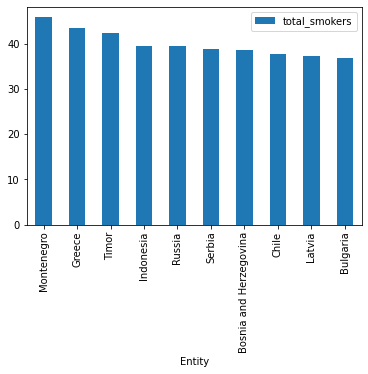

In [ ]:
merged_df.sort_values(['total_smokers'],ascending=False).head(10).plot.bar(x='Entity', y='total_smokers', rot=90)

[back to the top](#main)
<a id='Q2' name='Q2'></a>
## 2. How does the percentage of smokers correlate with covid mortality rate? 

In [ ]:
merged_df[['total_smokers', 'mortality_rate']].corr(method ='pearson')

,total_smokers,mortality_rate
total_smokers,1.00000,-0.06709
mortality_rate,-0.06709,1.00000


Drawing a scatter plot to observe any correlation between the total percentage ofsmokers and the mortality rate.

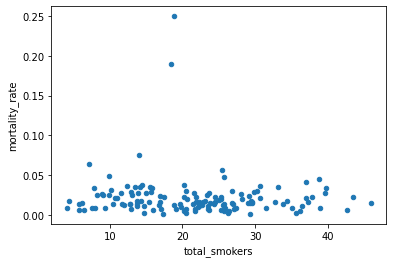

In [ ]:
merged_df.plot.scatter(x='total_smokers', y='mortality_rate')

As we can clearly see, the correlation coefficient is actually slightly negative and the scatter plot is seemingly random, so smoking does not, according to this investigation, increase the likeliness of dying from Covid-19.

However, sources say that it does in fact increase the risk of hospitalization and death. This may indicate that either:
1. My investgation is flawed, since it does not account for other factors and only looks at the percentage of smokers, not the percentage of sick smokers (which is not available);
2. The publications on the correlation are not credible and are simply fearmongering people to get clicks, since the population of smokers is quite high and they are likely to look up info about their risk of death.

[back to the top](#main)
<a id='Q3' name='Q3'></a>
## 3. Can we predict the total deaths based on total cases and percentage of smokers? 

Since the correlation between smoker population and mortality rate is negligible, this prediction will mostly be just predicting total deaths based on total cases, which is a simple ratio.

However, we will nevertheless compare the prediction with the simple ratio, to see if it is any more accurate.

We will first split the data into train and test datasets.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(merged_df, test_size=0.3)

For the simple ratio calculation we will just get the average mortality rate

In [ ]:
average_mortality_rate = sum(train['mortality_rate']) / len(train)
average_mortality_rate

0.02239495323131088

For the machine learning prediction we will use a linear regression model.

In [ ]:
results = np.array(train['total_deaths'])
data = np.array(train[['total_cases', 'total_smokers']])

from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(data, results)

First we evaluate the model we trained.

In [ ]:
test_results = np.array(test['total_deaths'])
test_data = np.array(test[['total_cases', 'total_smokers']])

model.score(test_data, test_results)

0.9134818168603437

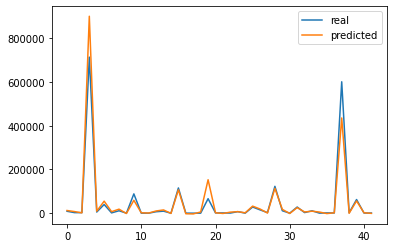

In [ ]:
plt.plot(range(len(test_results)), test_results, label='real')
plt.plot(range(len(test_results)), model.predict(test_data), label='predicted')
plt.legend()
plt.show()

Then we will evaluate the regular ratio calculation.

In [ ]:
predicted_test_results = [cases * average_mortality_rate for cases in test['total_cases']]

from sklearn.metrics import r2_score
r2_score(test_results, predicted_test_results)

0.8734140598030344

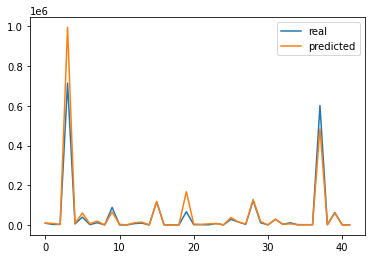

In [ ]:
plt.plot(range(len(test_results)), test_results, label='real')
plt.plot(range(len(test_results)), predicted_test_results, label='predicted')
plt.legend()
plt.show()

We can see that the score for the model is slightly better than the ratio's, so technically we can predict the total deaths based on total cases and percentage of smokers, but the difference between it and a simple ratio is negligible and may as well be a statistical error, when the sample size is so low.

If the Earth had thousands of countries, we could conclude with more certainty.